In [28]:
# %% [markdown]
# # How to use PyTorch LSTMs for time series regression

# %% [markdown]
# # Data

# %% [markdown]
# 1. Download the Air Passengers data.
# 2. Load the Air Passengers data into a DataFrame.

# %%
import pandas as pd

df = pd.read_csv("data-sets/air_passengers.csv", index_col="Month", parse_dates=True)
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)

# %%
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig = px.line(df, labels=dict(index="Date", value="Passengers"))
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

# %% [markdown]
# ## Create the target variable

# %%
forecast_lead = 1
target = f"lead{forecast_lead}"

df[target] = df["Passengers"].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]

# %% [markdown]
# ## Create a hold-out test set and preprocess the data

# %%
test_start = "1958-01-01"

df_train = df.loc[:test_start].copy()
df_test = df.loc[test_start:].copy()

print("Test set fraction:", len(df_test) / len(df))

# %% [markdown]
# ## Standardize the features and target, based on the training set

# %%
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

df_train["Passengers"] = (df_train["Passengers"] - target_mean) / target_stdev
df_test["Passengers"] = (df_test["Passengers"] - target_mean) / target_stdev

df_train[target] = (df_train[target] - target_mean) / target_stdev
df_test[target] = (df_test[target] - target_mean) / target_stdev

# %% [markdown]
# ## Create datasets that PyTorch `DataLoader` can work with

# %%
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, sequence_length=5):
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe['Passengers'].values).float().unsqueeze(1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]
        
# Continue the rest of the code as before


Test set fraction: 0.24475524475524477


Features shape: torch.Size([4, 3, 1])
Target shape: torch.Size([4])
Untrained test
--------
Test loss: 6.016740865177578

Epoch 0
---------
Train loss: 1.0110322308859654
Test loss: 5.241092880566915

Epoch 1
---------
Train loss: 0.8342921555574451
Test loss: 4.372982925838894

Epoch 2
---------
Train loss: 0.6266789635909455
Test loss: 3.103095041380988

Epoch 3
---------
Train loss: 0.390941378593977
Test loss: 1.7885334077808592

Epoch 4
---------
Train loss: 0.20999515183003886
Test loss: 1.0753844968146749

Epoch 5
---------
Train loss: 0.18094851846607135
Test loss: 1.107842404809263

Epoch 6
---------
Train loss: 0.17907020727372064
Test loss: 1.2174660621417894

Epoch 7
---------
Train loss: 0.1737264888943173
Test loss: 1.1193751986655924

Epoch 8
---------
Train loss: 0.1740726484651012
Test loss: 1.1198402245839436

Epoch 9
---------
Train loss: 0.1675821524362878
Test loss: 1.1360574956569407

Epoch 10
---------
Train loss: 0.1652771629659193
Test loss: 1.1015375351740255


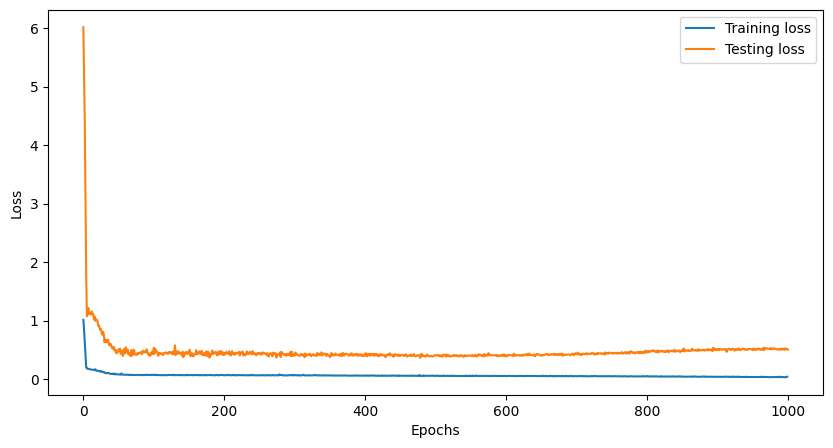

            lead1  Model forecast
Month                            
1949-01-01  118.0      117.441498
1949-02-01  132.0      124.121620
1949-03-01  129.0      136.214172
1949-04-01  121.0      128.806946
1949-05-01  135.0      123.692329
...           ...             ...
1960-07-01  606.0      576.453979
1960-08-01  508.0      566.964783
1960-09-01  461.0      411.681702
1960-10-01  390.0      391.551575
1960-11-01  432.0      341.564331

[144 rows x 2 columns]


In [29]:
# %% [markdown]
# ## Create the datasets and data loaders

# %%
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
torch.manual_seed(101)

batch_size = 4
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# %% [markdown]
# # The model and learning algorithm

# %%
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()

        return out


# %%
learning_rate = 1e-3
num_hidden_units = 32

model = ShallowRegressionLSTM(hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# %% [markdown]
# # Train

# %%
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

# Store losses per epoch
train_losses = []
test_losses = []

print("Untrained test\n--------")
initial_test_loss = test_model(test_loader, model, loss_function)
test_losses.append(initial_test_loss)
print()

for ix_epoch in range(1000):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    train_losses.append(train_loss)
    
    test_loss = test_model(test_loader, model, loss_function)
    test_losses.append(test_loss)
    print()


# Plot loss per epoch
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# %% [markdown]
# # Evaluation

# %%
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

# %%
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

# %%
fig = px.line(df_out, labels={'value': "Air Passengers", 'Month': 'Date'})
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False)
fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()
# fig.write_image("air_passengers_forecast.png", width=1200, height=600)
